
# 1. Read input files

In [79]:
# importing in all the important libraries
import time
import math
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.project_function import *
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import datetime as dt
import requests
import zipfile
import io

In [80]:
# TO PULL ADJ CLOSE DATA
# define the tickers and interval for needed data
tickers = ['GOOGL', 'META', 'AMZN', 'TSLA', 'F', 'KHC', 'PG', 'V', 'JNJ', 'GE', 'NVDA', 'MSFT', 'AAPL', 'CRM', 'IBM']
startDate = '2018-01-05'
# sets the start date to the nearest monday to make aligining data easier
startDate = pd.to_datetime(startDate) - pd.offsets.Week(weekday=0)
endDate = '2024-10-01'

# pull data from yfinance
adjClose = yf.download(tickers, start=startDate, end=endDate, interval = '1wk')['Adj Close']

# format the data to work with the optimization structure
adjClose.reset_index(inplace=True)
#title the date column
adjClose.columns = ['Date'] + tickers
# format the date column
adjClose['Date'] = adjClose['Date'].dt.strftime('%Y-%m-%d')

[*********************100%***********************]  15 of 15 completed


In [81]:
# TO PULL FACTOR RETURN DATA
# URLs for factor data
fiveFactorURL = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_TXT.zip'
momURL = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_daily_TXT.zip'
STRevURL = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_ST_Reversal_Factor_daily_TXT.zip'
LTRevURL = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_LT_Reversal_Factor_daily_TXT.zip'

# function to pull factor data from the web
def pull_factor_data(url, skipRows):
    response = requests.get(url)
    # pull the data from the site
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # get the name of the file
        fileName = z.namelist()[0]
    
        # read the .txt file
        with z.open(fileName) as file:
            return pd.read_csv(file, skiprows=skipRows, encoding='ISO-8859-1',  sep='\\s+', on_bad_lines='skip')

# pulling from Ken French database
fiveFactorRet = pull_factor_data(fiveFactorURL, 3)
momRet = pull_factor_data(momURL, 13)
STRevRet = pull_factor_data(STRevURL, 13)
LTRevRet = pull_factor_data(LTRevURL, 13)
# concatenating the factor data
dailyFactorRet = pd.concat([fiveFactorRet, momRet, STRevRet, LTRevRet])

# format the data to work with the optimization structure
dailyFactorRet.reset_index(inplace=True)
# title the date column
dailyFactorRet.columns = ['Date'] + dailyFactorRet.columns.tolist()[1:]
# format the date column
dailyFactorRet['Date'] = pd.to_datetime(dailyFactorRet['Date'], format='%Y%m%d')
# filter based on start and end date (note including a few days before start date in order to do the weekly sums)
dailyFactorRet = dailyFactorRet[(dailyFactorRet['Date'] >= pd.to_datetime(startDate) - pd.DateOffset(days=6)) & (dailyFactorRet['Date'] <= endDate)]

# data is daily but it needs to be weekly
# make a weekly data frame
factorRet = pd.DataFrame()

# sum daily data for each week
for weekEnd in pd.date_range(start=startDate, end=endDate, freq='W-MON'):
    # figure out the week start
    weekStart = weekEnd - pd.DateOffset(days=6)
    # filter the data for the particular week
    weekData = dailyFactorRet[(dailyFactorRet['Date'] >= weekStart) & (dailyFactorRet['Date'] <= weekEnd)]
    # sum up the data for that week
    weeklySum = weekData[dailyFactorRet.columns[1:]].sum()
    # format it so it can be added to the data frame
    weekDataFrame = pd.DataFrame([[weekEnd] + weeklySum.tolist()], columns=['Date'] + weeklySum.index.tolist())
    # add the weekly sum to the data frame
    factorRet = pd.concat([factorRet, weekDataFrame])

In [82]:
# set date as the index
adjClose.set_index('Date', inplace=True)
factorRet.set_index('Date', inplace=True)

# set the dates to pandas dates
adjClose.index = pd.to_datetime(adjClose.index)
factorRet.index = pd.to_datetime(factorRet.index)

In [83]:
# set the initial budget to invest
initialVal = 100000

# set the length of investment period (in weeks)
investPeriod = 26

# divide the factor returns by 100
factorRet = factorRet/100

# separate out the rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF']

In [84]:
# identify the tickers and the dates
tickers = adjClose.columns
dates = factorRet.index

In [85]:
# calculate the stocks weekly excess returns
returns = adjClose.pct_change(1)

# adjust returns based on risk free rate
returns = returns - np.diag(riskFree.values) @ np.ones_like(returns.values)

In [86]:
# check to make sure datasets are aligned
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# 2. Run the program

In [87]:
# set testing period start
testStart = returns.index[0] + pd.offsets.DateOffset(weeks=156)

# calculate end of first testing period
testEnd = testStart + pd.offsets.DateOffset(weeks=investPeriod) - pd.offsets.DateOffset(weeks=1)

# set the end of calibration period
calEnd = testStart

# calculate the total number of investment periods
NoPeriods = math.ceil((returns.index[-1] - testStart).days // (investPeriod * 7))

# calculate the number of assets
n  = len(tickers)

# preallocate space for the portfolio weights (x0 will be used to calculate the turnover rate)
x  = np.zeros([n, NoPeriods])
x0 = np.zeros([n, NoPeriods])

# preallocate space for the portfolio per period value and turnover
currentVal = np.zeros([NoPeriods, 1])
turnover   = np.zeros([NoPeriods, 1])

# initiate counter for the number of observations per investment period
toDay = 0

# measure runtime: start the clock
start_time = time.time()

# empty list to measure the value of the portfolio over the period
portfValue = []

# loop over testing periods
for t in range(NoPeriods):
    # subset the returns and factor returns corresponding to the current calibration period.
    periodReturns = returns[returns.index <= calEnd]
    periodFactRet = factorRet[factorRet.index <= calEnd]

    # calculate the current prices
    current_price_idx = (calEnd - pd.offsets.DateOffset(weeks=1) <= adjClose.index)&(adjClose.index < calEnd)
    currentPrices = adjClose[current_price_idx]

    # subset the prices corresponding to the current out-of-sample test period.
    periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
    periodPrices = adjClose[periodPrices_idx]

    # check that period is the right length and that there is only 1 set of current prices
    assert len(periodPrices) == investPeriod
    assert len(currentPrices) == 1
    
    # set the initial value of the portfolio or update the portfolio value
    if t == 0:
        currentVal[0] = initialVal
    else:
        currentVal[t] = currentPrices @  NoShares.values.T
        # store the current asset weights (before optimization takes place)
        x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]

    #----------------------------------------------------------------------
    # Portfolio optimization
    #----------------------------------------------------------------------
    
    # run the project function for this period
    x[:,t] = project_function(periodReturns, periodFactRet, x0[:,t])

    # calculate the turnover rate
    if t > 0:
        turnover[t] = np.sum(np.abs(x[:,t] - x0[:,t]))

    # calculate the number of shares your portfolio holds per stock
    NoShares = x[:,t]*currentVal[t]/currentPrices

    # update the counter for the number of observations per investment period
    fromDay = toDay
    toDay = toDay + len(periodPrices)

    # weekly portfolio value during the out-of-sample window
    portfValue.append(periodPrices@ NoShares.values.T)

    # update the calibration and out-of-sample test periods
    testStart = testStart + pd.offsets.DateOffset(weeks=investPeriod)
    testEnd   = testStart + pd.offsets.DateOffset(weeks=investPeriod) - pd.offsets.DateOffset(weeks=1)
    calEnd    = testStart

portfValue = pd.concat(portfValue, axis = 0)
end_time = time.time()

# 3. Results

In [88]:
#--------------------------------------------------------------------------
# Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
#-----------------------------------------------------------------------

# calculate the observed portfolio returns
portfRets = portfValue.pct_change(1).iloc[1:,:]

# calculate the portfolio excess returns
portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

# calculate the portfolio Sharpe ratio
SR = ((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std()

# calculate the average turnover rate
avgTurnover = np.mean(turnover[1:])

# print Sharpe ratio and Avg. turnover
print("Elasped time is "+ str(end_time - start_time) + ' seconds')
print('Sharpe ratio: ', str(SR[0]))
print('Avg. turnover: ', str(avgTurnover))

Elasped time is 0.12678194046020508 seconds
Sharpe ratio:  0.13579531465890815
Avg. turnover:  0.6632799172697148


<Figure size 640x480 with 0 Axes>

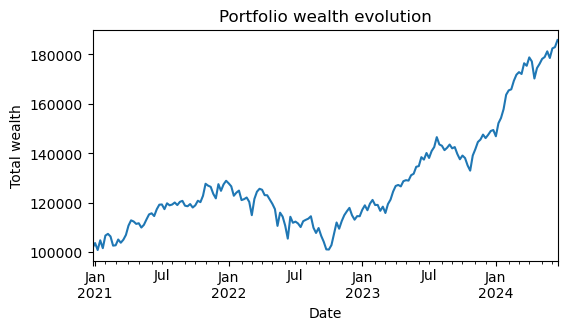

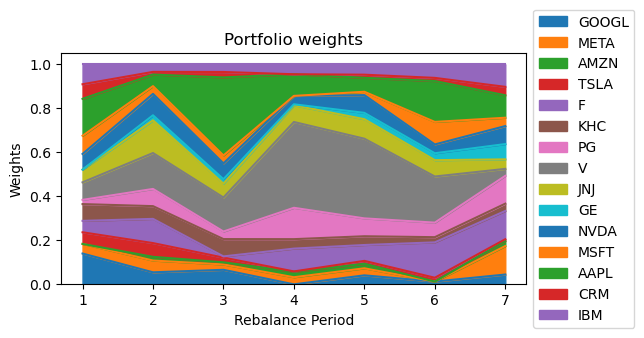

In [89]:
#--------------------------------------------------------------------------
# Portfolio wealth evolution plot
#--------------------------------------------------------------------------

# plot the results of the portfolio wealth
fig = plt.figure(1)
portfValue.plot(title = 'Portfolio wealth evolution',
                ylabel = 'Total wealth',
                figsize = (6, 3),
                legend = False)
plt.savefig("images/wealth.svg")

#--------------------------------------------------------------------------
# Portfolio weights plot
#--------------------------------------------------------------------------

# plot the results of the portfolio weights
fig2 = plt.figure(2);
x[x < 0] = 0
weights = pd.DataFrame(x[(x >0).any(axis=1)], index = tickers[(x >0).any(axis=1)])
weights.columns = [col + 1 for col in weights.columns]
weights.T.plot.area(title = 'Portfolio weights',
                  ylabel = 'Weights', xlabel = 'Rebalance Period',
                  figsize = (6, 3),
                  legend = True, stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("images/weights.svg");
#
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Program End